Симулируем...: 100%|██████████| 1600/1600 [00:03<00:00, 509.91it/s] 


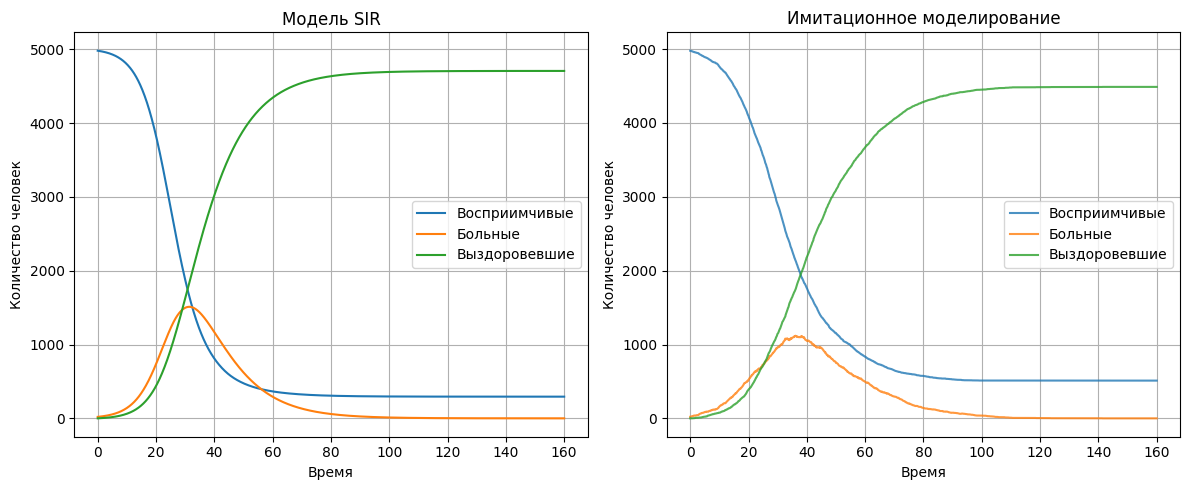

Анимация сохранена: epidemic_simulation.gif


In [ ]:
#SIR
# ЭПИДЕМИЯ

# Программа для моделирования распространения эпидемии
# с помощью системы дифференциальных уравнений SIR и с помощью имитационного моделирования (Agent-Based Model)
# Строятся графики количества восприимчивых (S), больных (I) и выздоровевших (R) согласно этим двум моделям
# По итогу имитационного моделирования также сохраняется анимация с хаотично движущимися и заражающими друг друга агентами

# ЗАДАНИЯ ПО ДОРАБОТКЕ

# 1) Разобраться в коде и его математических основаниях. Поэкспериментировать с параметрами моделей
# 2) Изучить и реализовать более сложные эпидемиологические модели,
# в т.ч. учитывающие возможность гибели от болезни, инкубационный период, нестойкость иммунитета и другие факторы,
# попробовать соотнести результаты моделирования с реальными эпидемиями

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from scipy.spatial import cKDTree
from tqdm import tqdm

# Модель SIR
def sir_model(t, y, beta, gamma):
    S, I, R = y
    N = S + I + R
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# Подбор параметров имитационного моделирования
# В SIR вероятность заразиться за малое время dt равна beta*(I/N)*dt
# В имитационной модели оно в среднем равно p_trans * (I * pi r^2 / box_size^2)
# p_trans - коэффициент заразности, он умножается на количество больных в радиусе r
# Подбираем p_trans, чтобы вероятности соответствовали друг другу
# Вероятность выздороветь тоже соответствует SIR (убедитесь в этом)
def calibrate_abm_from_sir(beta, gamma, N, box_size, infection_radius, dt):

    area = box_size ** 2
    contact_area = np.pi * infection_radius ** 2

    p_trans = beta * dt * area / (N * contact_area)
    p_trans = float(np.clip(p_trans, 0.0, 1.0))

    p_rec = 1.0 - np.exp(-gamma * dt)
    p_rec = float(np.clip(p_rec, 0.0, 1.0))

    return p_trans, p_rec

rng = np.random.default_rng()

# Параметры SIR
N = 5000 # Численность населения
I0 = 20 # Сколько больных в начале
R0_init = 0
S0 = N - I0 - R0_init
beta = 0.3
gamma = 0.1

# Временная сетка SIR
T0, T1 = 0.0, 160.0
num_points = 1600

t_eval = np.linspace(T0, T1, num_points)
dt = float(t_eval[1] - t_eval[0])

# Решаем SIR
sol = solve_ivp(
    sir_model,
    (T0, T1),
    [S0, I0, R0_init],
    args=(beta, gamma),
    t_eval=t_eval,
)

# ABM
num_agents = N
initial_infected = I0

box_size = 100.0
step_size = 1.0  # подвижность агентов

infection_radius = 2.0

# Согласуем количество шагов ABM с t_eval
max_steps = len(t_eval)

# Калибруем вероятности ABM по SIR
infection_prob, recovery_prob = calibrate_abm_from_sir(
    beta=beta,
    gamma=gamma,
    N=N,
    box_size=box_size,
    infection_radius=infection_radius,
    dt=dt,
)

# Частота сохранения кадров для GIF
frame_stride = 10

# Состояния: 0 - S, 1 - I, 2 - R
states = np.zeros(num_agents, dtype=np.int8)
positions = rng.random((num_agents, 2)) * box_size

infected_indices = rng.choice(num_agents, size=initial_infected, replace=False)
states[infected_indices] = 1

S_history = np.empty(max_steps, dtype=int)
I_history = np.empty(max_steps, dtype=int)
R_history = np.empty(max_steps, dtype=int)

frames = []

# Отражение агентов от стен
def reflect_in_box(pos, L):
    low = pos < 0
    pos[low] = -pos[low]
    high = pos > L
    pos[high] = 2 * L - pos[high]
    pos[:] = np.clip(pos, 0, L)
    return pos


for step in tqdm(range(max_steps), desc="Симулируем..."):
    # Случайное блуждание
    moves = (rng.random((num_agents, 2)) - 0.5) * 2.0 * step_size # массив случайных сдвигов для агентов
    positions += moves
    positions = reflect_in_box(positions, box_size)

    # Выздоровление
    infected = (states == 1)
    if infected.any():
        recover_now = infected & (rng.random(num_agents) < recovery_prob)
        states[recover_now] = 2

    # Заражение
    infected_idx = np.where(states == 1)[0]
    susceptible_idx = np.where(states == 0)[0]

    if infected_idx.size and susceptible_idx.size:
        # KD-tree по координатам инфицированных: быстро ищем соседей в радиусе r
        tree = cKDTree(positions[infected_idx])
        # Для каждого восприимчивого - список соседей-инфицированных
        neigh_lists = tree.query_ball_point(positions[susceptible_idx], r=infection_radius)
        # k = число инфицированных в радиусе
        k = np.fromiter((len(lst) for lst in neigh_lists), dtype=int, count=susceptible_idx.size)
        # Вероятность заражения при k независимых контактах равна p = 1 - (1 - p_trans)^k
        p_inf = 1.0 - np.power(1.0 - infection_prob, k)

        new_inf = rng.random(susceptible_idx.size) < p_inf
        states[susceptible_idx[new_inf]] = 1

    # Статистика
    S_history[step] = int(np.sum(states == 0))
    I_history[step] = int(np.sum(states == 1))
    R_history[step] = int(np.sum(states == 2))

    # Кадры
    if step % frame_stride == 0:
        frames.append((positions.copy(), states.copy()))

# График сравнения моделей
fig_cmp = plt.figure(figsize=(12, 5))

ax1 = fig_cmp.add_subplot(1, 2, 1)
ax1.plot(sol.t, sol.y[0], label="Восприимчивые")
ax1.plot(sol.t, sol.y[1], label="Больные")
ax1.plot(sol.t, sol.y[2], label="Выздоровевшие")
ax1.set_xlabel("Время")
ax1.set_ylabel("Количество человек")
ax1.set_title("Модель SIR")
ax1.grid(True)
ax1.legend()

ax2 = fig_cmp.add_subplot(1, 2, 2)
t_abm = np.arange(max_steps) * dt
ax2.plot(t_abm, S_history, alpha=0.8, label="Восприимчивые")
ax2.plot(t_abm, I_history, alpha=0.8, label="Больные")
ax2.plot(t_abm, R_history, alpha=0.8, label="Выздоровевшие")
ax2.set_xlabel("Время")
ax2.set_ylabel("Количество человек")
ax2.set_title("Имитационное моделирование")
ax2.grid(True)
ax2.legend()

fig_cmp.tight_layout()

plt.show()
plt.close(fig_cmp)

color_map = np.array(["blue", "red", "green"], dtype=object)

fig_anim, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
ax.set_title(
    "Эпидемия:\n"
    f"beta={beta}, gamma={gamma}, dt={dt:.3f}\n"
    f"r={infection_radius}, p_trans≈{infection_prob:.4f}, p_rec≈{recovery_prob:.4f}"
)

pos0, st0 = frames[0]
scat = ax.scatter(pos0[:, 0], pos0[:, 1], c=color_map[st0], s=10)

def animate_frame(i):
    pos, st = frames[i]
    scat.set_offsets(pos)
    scat.set_color(color_map[st])
    return (scat,)

ANIMATION_FPS = 10

ani = animation.FuncAnimation(
    fig_anim,
    animate_frame,
    frames=len(frames),
    interval=1000 / ANIMATION_FPS,
    blit=True,
)

gif_path = "epidemic_simulation.gif"
ani.save(gif_path, writer="pillow", fps=ANIMATION_FPS)
plt.close(fig_anim)

print(f"Анимация сохранена: {gif_path}")
